In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
transform=transforms.ToTensor()

train_data=datasets.MNIST('./data/', train=True,
                          transform=transform, download=True)
test_data=datasets.MNIST('./data/', train=False,
                          transform=transform, download=True)

num_workers=0
batch_size=64
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)

### Visulize the data

torch.Size([64, 1, 28, 28]) torch.Size([64])


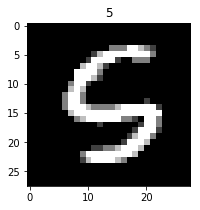

In [3]:
dataiter=iter(train_loader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

images=images.numpy()
img=np.squeeze(images[0])

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(1,1,1)
ax.imshow(img, cmap='gray')
ax.set_title(labels[0].item())
plt.show()

### Define the Model

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        
        self.fc1=nn.Linear(input_size, hidden_size*4)
        self.fc2=nn.Linear(hidden_size*4, hidden_size*2)
        self.fc3=nn.Linear(hidden_size*2, hidden_size)
        
        self.dropout=nn.Dropout(0.3)

        self.fc4=nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x=x.view(-1, 28*28)
        x=F.leaky_relu(self.fc1(x), 0.2)
        x=self.dropout(x)
        x=F.leaky_relu(self.fc2(x), 0.2)
        x=self.dropout(x)
        x=F.leaky_relu(self.fc3(x), 0.2)
        x=self.dropout(x)
        out=self.fc4(x)
        return out
    
d_input_size=28*28
d_hidden_size=32
d_output_size=1

D = Discriminator(d_input_size, d_hidden_size, d_output_size)
print(D)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.3)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [5]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        
        self.fc1=nn.Linear(input_size, hidden_size)
        self.fc2=nn.Linear(hidden_size, hidden_size*2)
        self.fc3=nn.Linear(hidden_size*2, hidden_size*4)
        
        self.dropout=nn.Dropout(0.3)

        self.fc4=nn.Linear(hidden_size*4, output_size)
        
    def forward(self, x):
        x=F.leaky_relu(self.fc1(x), 0.2)
        x=self.dropout(x)
        x=F.leaky_relu(self.fc2(x), 0.2)
        x=self.dropout(x)
        x=F.leaky_relu(self.fc3(x), 0.2)
        x=self.dropout(x)
        out=F.tanh(self.fc4(x))
        return out
    
g_input_size=100
g_hidden_size=32
g_output_size=28*28

G=Generator(g_input_size, g_hidden_size, g_output_size)
print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.3)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (dropout): Dropout(p=0.3)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
)


### Discriminator and Generator Losses

In [6]:
def real_loss(D_out, smooth=False):
    batch_size=D_out.size(0)
    if smooth:
        labels=torch.ones(batch_size)*0.9
    else:
        labels=torch.ones(batch_size)
    
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size=D_out.size(0)
    labels=torch.zeros(batch_size)
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(), labels)
    return loss        

### Optimizer

In [7]:
lr=0.002
d_optimizer=optim.Adam(D.parameters(), lr)
g_optimizer=optim.Adam(G.parameters(), lr)

### Trainning

In [8]:
num_epochs=5
samples=[]
losses=[]
print_every=400

sample_size=16
fixed_z=np.random.uniform(-1,1, size=(sample_size, g_input_size))
fixed_z=torch.from_numpy(fixed_z).float()
print(fixed_z.shape)

D.train()
G.train()

for epoch in range(num_epochs):
    
    for batch_i, (real_images,_) in enumerate(train_loader, 1):
        batch_size=real_images.size(0)
        real_images=real_images*2-1
        
        #
        # DISCRIMINATOR TRAIN
        #
        
        d_optimizer.zero_grad()
        D_real=D(real_images)
        d_real_loss=real_loss(D_real, smooth=True)
        
        z=np.random.uniform(-1, 1, size=(batch_size, g_input_size))
        z=torch.from_numpy(z).float()
        fake_images=G(z)
        
        D_fake=D(fake_images)
        d_fake_loss=fake_loss(D_fake)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        #
        # GENERATOR TRAIN
        #
        g_optimizer.zero_grad()
        z=np.random.uniform(-1, 1, size=(batch_size, g_input_size))
        z=torch.from_numpy(z).float()
        fake_images=G(z)
        D_fake=D(fake_images)
        g_loss=real_loss(D_fake)
        
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))        
            

torch.Size([16, 100])


D:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/    5] | d_loss: 3.1048 | g_loss: 0.8446
Epoch [    1/    5] | d_loss: 1.9551 | g_loss: 0.7459
Epoch [    2/    5] | d_loss: 1.2846 | g_loss: 0.8876
Epoch [    2/    5] | d_loss: 1.2570 | g_loss: 1.8389
Epoch [    3/    5] | d_loss: 1.3714 | g_loss: 1.0527
Epoch [    3/    5] | d_loss: 0.9488 | g_loss: 2.3094
Epoch [    4/    5] | d_loss: 0.8867 | g_loss: 2.6263
Epoch [    4/    5] | d_loss: 1.1596 | g_loss: 1.1080
Epoch [    5/    5] | d_loss: 1.1570 | g_loss: 2.0669
Epoch [    5/    5] | d_loss: 1.1091 | g_loss: 1.2791
